# Reward building

# Overview of ideas:

Utility / potential / shaping combined reward:
- Align ball:
	- expected values are higher near the player team goal - not that great, need to make sure weight is not that high
	- we need an alignment score that is highest near the ball, but not too far or too close
- Ball to goal wall distance / y coord:
	- the higher the y axis value the more the team pushes the opponent team to defend
- Distance ball to goal: 
	- one of the two best possible rewards
- Distance player to ball:
	- increases control strength
- Velocity ball to goal: 
	- one of the two best possible rewards
	- increases probability of scoring
- Velocity player to ball:
	- mediocre as a reward
	- idea: enhance by player to ball and ball to goal offensive vector alignment
    - idea extended: include player to ball distance, players that are far away have a very low chance of scoring:
        - we need a velocity player to ball score that is highest near the ball, but not too far or too close (similar to the align ball idea)
    - reward name idea: offensive potential

Reward:
- Touch ball with acceleration (difference between current and previous ball linear velocity) toward goal (current ball linear velocity vector and ball to goal position vector alignment)
- Save boost reward inversely weighted by the absolute value of the utility score:
	- the larger or smaller the utility, the more in demand would be to use boost
- Event rewards:
	- Demolish and demolished
	- Goal / team goal and concede
	- Shot (as detected by the game)
	- Save (as detected by the game)

------

- But what kind of weights?
- How to distribute reward between multiple agents of different purposes?


Import needed libraries

In [1]:
import sys
from pathlib import Path

# Modify this as you wish, used for importing custom project packages, such as `utils`
project_path = str(Path.home()) + "\\Projects\\rlgym_demo"

sys.path.insert(0, project_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.analysis import plotting, generate
from utils.analysis.reward_functions import common, custom
from rlgym.utils import common_values
import pandas as pd
import seaborn as sns

Retrieve arena positions

In [3]:
arena_positions = plotting.arena_positions

Generate uniformly distributed dummy data

In [4]:
grid_positions = generate.grid_positions()
player_velocities = np.linspace((1327.9,) * 3, (0,) * 3, 8)
ball_velocities = np.linspace((3464.1,) * 3, (0,) * 3, 8)
forward_vectors = generate.sphere_points()

Training measurements

In [5]:
# maximum episode length in seconds
max_episode_len = 300
# default frame skip
frame_skip = 8
# the number of seconds it takes the gamma exponential to reach 0.5
half_life_seconds = 10
# game physics engine runs at 120 Hz\fps
fps = 120 // frame_skip
# inverse function gamma computation
gamma = np.exp(np.log(0.5) / (fps * half_life_seconds))

In [6]:
gamma

0.9953896791032291

Average values for a standard game, based on ballchasing data

In [7]:
average_ball_vel = common_values.BALL_MAX_SPEED * 0.6 // fps
average_car_vel = common_values.CAR_MAX_SPEED * 0.65 // fps

average_ball_height = 900
average_car_height = 300
# We assume a case for which the blue team is winning in offense / scoring a goal
average_ball2goal_vel = 2000 // fps
average_car2ball_vel = 850 // fps

We set up a 2v2 scenario for blue offense

In [8]:
ball_position = np.array([-1800, 1800, 400])
ball_lin_velocity = np.array([1000, 3500, -40], dtype=float)

blue_positions = np.array([[100, 400, 200], [1200, -600, 300]])
orange_positions = np.array([[-2000, 3500, 250], [2300, 3000, 50]])
player_positions = (blue_positions, orange_positions)
team_idx = [0, 0, 1, 1]

blue_lin_vels = np.array([[-1200, 600, 0], [-1200, 900, 0]])
orange_lin_vels = np.array([[200, -700, 150], [-1000, -1100, 400]])
player_lin_vels = (blue_lin_vels, orange_lin_vels)

## Utility function

We first compute necessary reward functions

### Align ball

In [9]:
align_ball_zs = common.align_ball(arena_positions, ball_position, defense=0.5, offense=0.5)

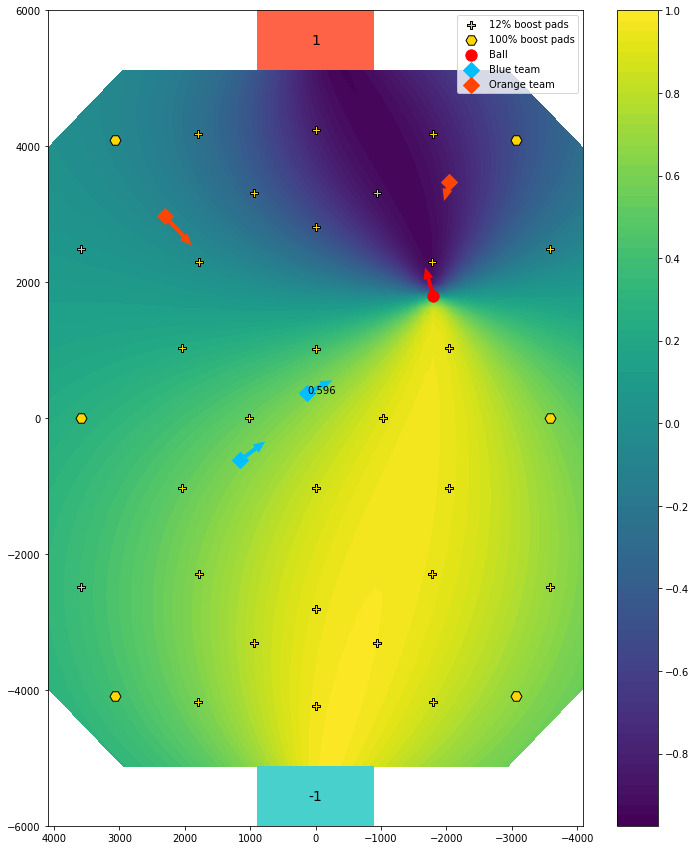

In [10]:
plotting.arena_contour(align_ball_zs,
                      ball_position=ball_position,
                      ball_lin_vel=ball_lin_velocity,
                      player_positions=player_positions,
                      player_lin_vels=player_lin_vels)

### Ball y coord

In [11]:
ball_y_coord_val = common.ball_y_coord(ball_position[None])

In [12]:
ball_y_coord_val

array([0.34530718])

### Distance ball to goal

In [13]:
signed_liu_dist_ball2goal_val = custom.signed_liu_dist_ball2goal(ball_position, dispersion=1.1)

In [14]:
signed_liu_dist_ball2goal_val

0.39841623309655283

### Distance player to ball

In [15]:
liu_dist_player2ball_zs = custom.liu_dist_player2ball(arena_positions, ball_position)

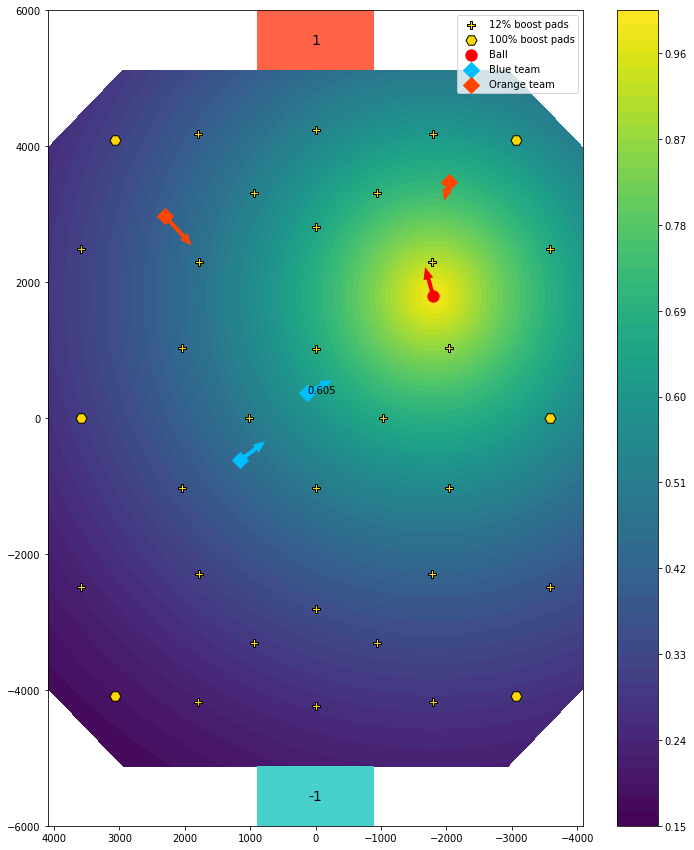

In [16]:
plotting.arena_contour(liu_dist_player2ball_zs,
                       ball_position=ball_position,
                       ball_lin_vel=ball_lin_velocity,
                       player_positions=player_positions,
                       player_lin_vels=player_lin_vels
                      )

### Velocity ball to goal

In [17]:
velocity_ball2goal_val = common.velocity_ball2goal(ball_position[None], ball_lin_velocity)

In [18]:
velocity_ball2goal_val

array([0.60184678])

### Velocity player to ball

In [19]:
velocity_player2ball_zs = common.velocity_player2ball(arena_positions, 
                                                       blue_lin_vels[0],
                                                       ball_position)

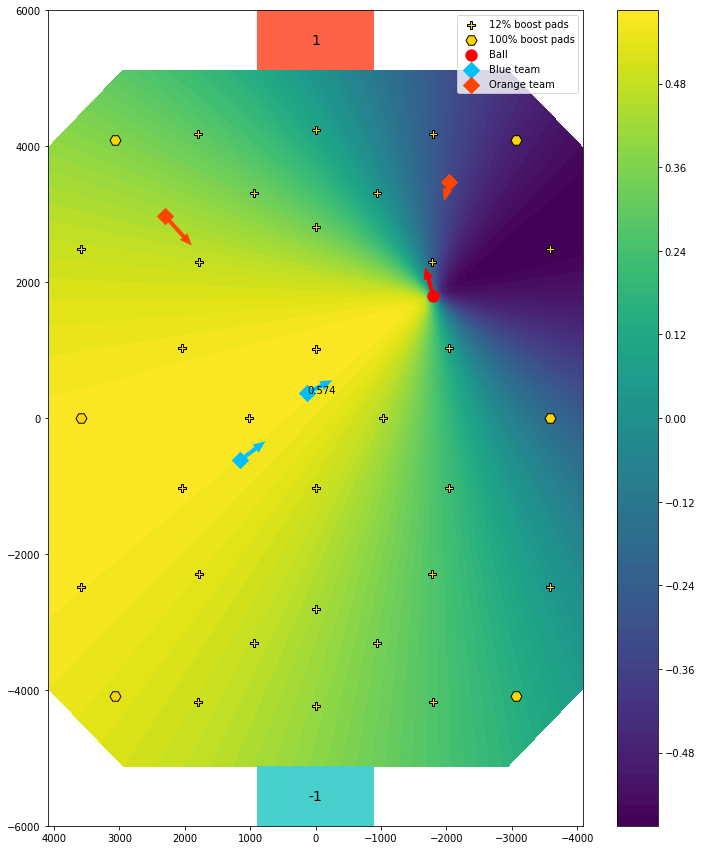

In [20]:
plotting.arena_contour(velocity_player2ball_zs,
                       ball_position,
                       ball_lin_velocity,
                       player_positions,
                       player_lin_vels
                      )

### Offensive potential

In [21]:
def offensive_potential(player_position, 
                        ball_position, 
                        player_lin_velocity,
                        defense=0.5, 
                        offense=0.5,
                        orange=False):
    """
    Offensive potential function. When the player to ball and ball to goal vectors align 
    we should reward player to ball velocity.
    """
    
    player2ball_vel = common.velocity_player2ball(player_position, player_lin_velocity, ball_position) + 1e-8
    align_ball_rew = common.align_ball(player_position, ball_position,
                                       defense, offense, orange) + 1e-8
    # logical OR
    # when both alignment and player to ball velocity are negative we must get a negative output
    sign = (((player2ball_vel >= 0) | (align_ball_rew >= 0)) - 0.5) * 2
    rew = (align_ball_rew * player2ball_vel)
    # square root because we multiply two values between -1 and 1
    # "weighted" product (n_1 * n_2 * ... * n_N) ^ (1 / N)
    return np.sqrt(np.abs(rew)) * np.sign(rew) * sign

In [22]:
offensive_potential_zs = offensive_potential(arena_positions,
                                             ball_position, 
                                             blue_lin_vels[0],
                                             0.5, 0.5
                                            )

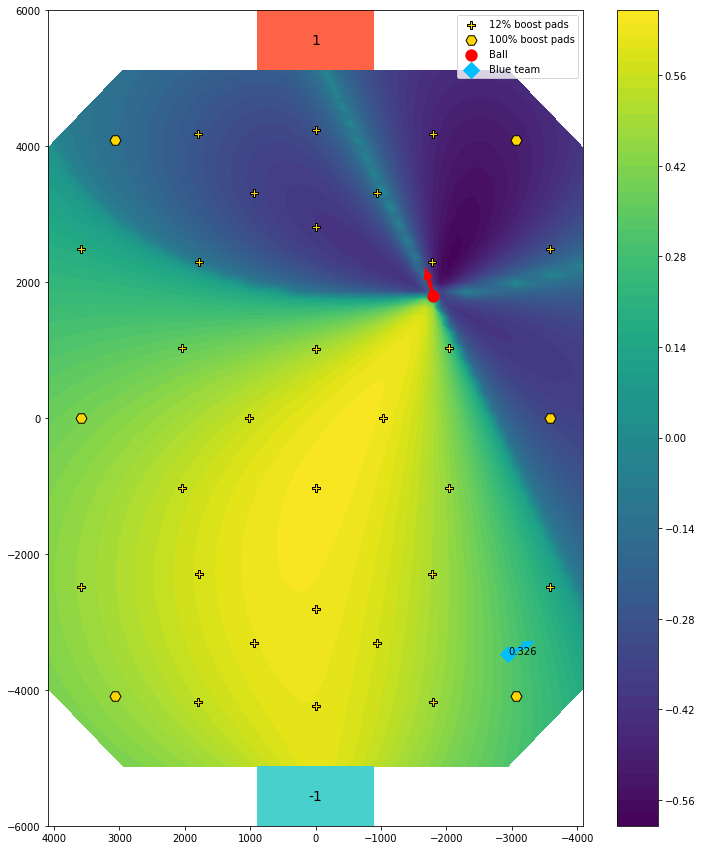

In [23]:
plotting.arena_contour(offensive_potential_zs,
                       ball_position, 
                       ball_lin_velocity, 
                       np.array([[-3000, -3500, 100]]),
                       blue_lin_vels[0][None])

In [24]:
some_vel = np.array([400, 1500, 80])
# some_vel = np.array([-800, 1000, 80])
# some_vel = np.array([1800, 0, 0])
some_vel = np.array([0, -1800, 50])

In [25]:
some_pos = np.array([-1300, 3000, 150])
# some_pos = np.array([-2400, 0, 150])
# some_pos = np.array([-2400, -2000, 150])
some_pos = np.array([0, -2400, 150])

In [26]:
some_ball_pos = np.array([0, 0, 93])

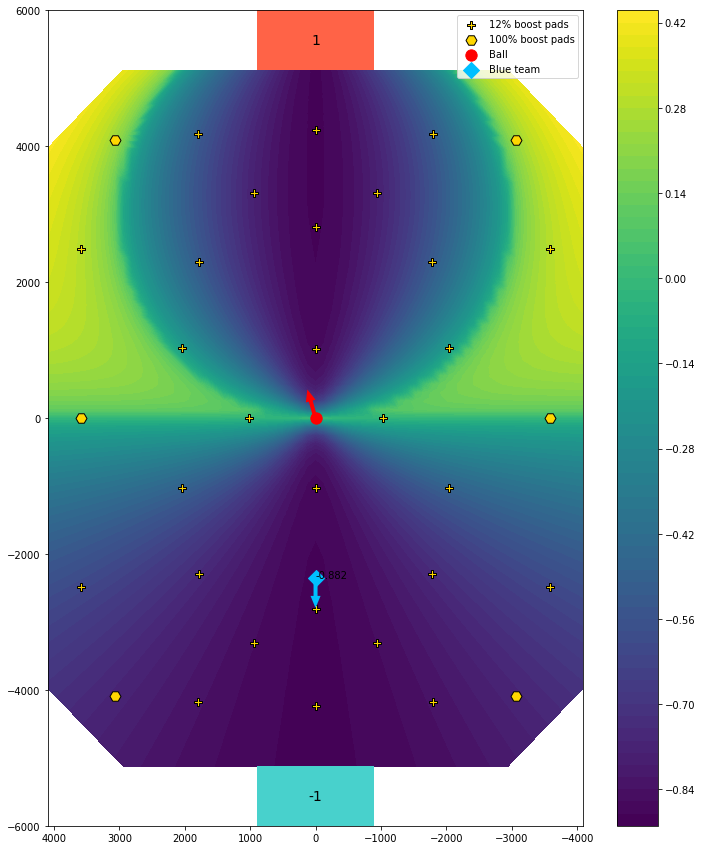

In [27]:
plotting.arena_contour(offensive_potential(arena_positions, some_ball_pos, some_vel, 0, 1),
                       some_ball_pos, 
                       ball_lin_velocity, 
                       some_pos[None],
                       some_vel[None])